# 大黒海釣り施設、アジ釣果分析その１

## モジュールのインポート

In [2]:
# モジュールのインポート

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
import jpholiday
import sqlite3
import seaborn as sns

# グラフサイズ変更。既定より大きくする

plt.rcParams['figure.figsize'] = [15, 10]

# seaborn グラフにグリッド線を追加

sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

## データのロードと変換

In [7]:
# 大黒、アジに絞ってSQLite3データベースを検索

conn = sqlite3.connect("../data/fishing_result.db")
sql = '''
select
    r.Date,
    r.Species,
    r.Count,
    r.SizeMin,
    r.SizeMax,
    c.WaterTemp,
    c.Quantity
from
    fishing_results r,
    fishing_comments c
where
    r.Date = c.Date
    and r.Point = c.Point
    and r.Species = 'アジ'
    and r.Point = 'daikoku'
'''
df=pd.read_sql_query(sql, conn)
df.head()

,Date,Species,Count,SizeMin,SizeMax,WaterTemp,Quantity
0,2021-04-13,タコ,2,None,None,16.0,104.0


In [29]:
# 土日祝日化判定列を追加

df['Date'] = pd.to_datetime(df.Date)
def isBizDay(Date):
    if Date.weekday() >= 5 or jpholiday.is_holiday(Date):
        return 'Holiday'
    else:
        return 'WeekDay'

df['BizDay'] = df.apply(lambda x: isBizDay(x.Date), axis=1)

# 日付を索引にセット

df = df.set_index('Date')
df.head()

,Count,SizeMin,SizeMax,WaterTemp,Quantity,BizDay
Date,,,,,,
2021-04-02,147.0,10.0,25.0,16.0,289.0,WeekDay
2021-04-01,134.0,13.0,25.0,16.0,232.0,WeekDay
2021-03-31,130.0,15.0,25.0,15.5,298.0,WeekDay
2021-03-30,192.0,15.0,20.0,15.0,305.0,WeekDay
2021-03-29,42.0,13.0,17.0,14.0,299.0,WeekDay


## 平日、休日の入場者数比較

<AxesSubplot:xlabel='BizDay', ylabel='Quantity'>

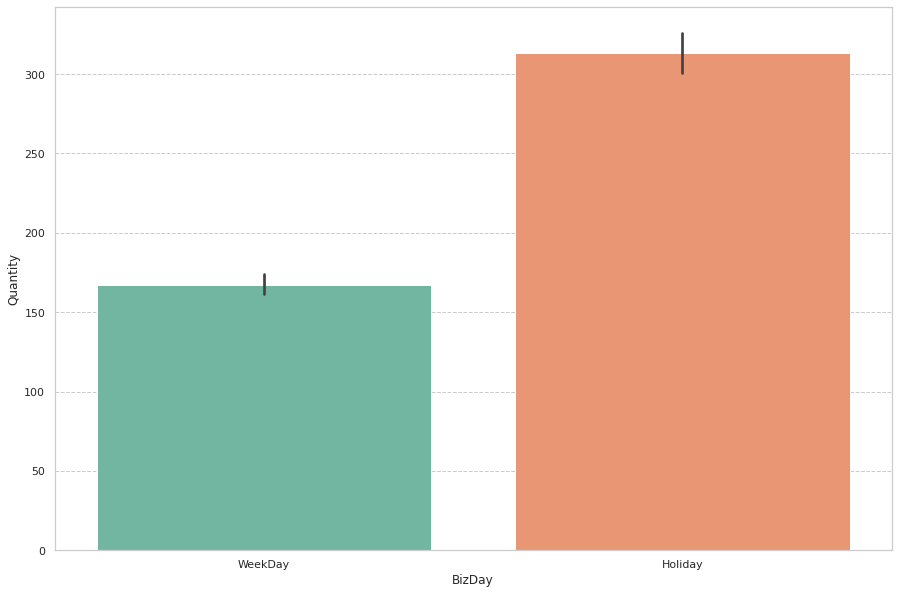

In [30]:
# 入場者数の比較

sns.barplot(x='BizDay', y='Quantity', data=df, palette='Set2')

In [31]:
# 平日と休日の比較

df.groupby('BizDay').mean()

,Count,SizeMin,SizeMax,WaterTemp,Quantity
BizDay,,,,,
Holiday,195.714286,14.150183,25.772894,18.960517,313.003663
WeekDay,202.242202,14.387868,26.996324,19.209761,167.385609


In [32]:
# seaborn でプロットしやすいようにデータフレームを横縦変換する

df2 = df[['Count', 'SizeMin', 'SizeMax','WaterTemp', 'Quantity']]
df2 = df2.stack().reset_index()
df2 = df2.rename(columns={'level_1': 'Metric', 0: 'Value'})

# 平日、休日判定列を追加

df2['BizDay'] = df2.apply(lambda x: isBizDay(x.Date), axis=1)

# 日付を索引にセットして、各年月日列を追加

df3 = df2.set_index('Date')
df3['Year'] = df3.index.year
df3['Month'] = df3.index.month
df3['DayOfYear'] = df3.index.dayofyear
df3['WeekOfYear'] = df3.index.strftime('%U').astype(int) # df3.index.week
df3.head()

,Metric,Value,BizDay,Year,Month,DayOfYear,WeekOfYear
Date,,,,,,,
2021-04-02,Count,147.0,WeekDay,2021,4,92,13
2021-04-02,SizeMin,10.0,WeekDay,2021,4,92,13
2021-04-02,SizeMax,25.0,WeekDay,2021,4,92,13
2021-04-02,WaterTemp,16.0,WeekDay,2021,4,92,13
2021-04-02,Quantity,289.0,WeekDay,2021,4,92,13


<AxesSubplot:xlabel='Month', ylabel='Value'>

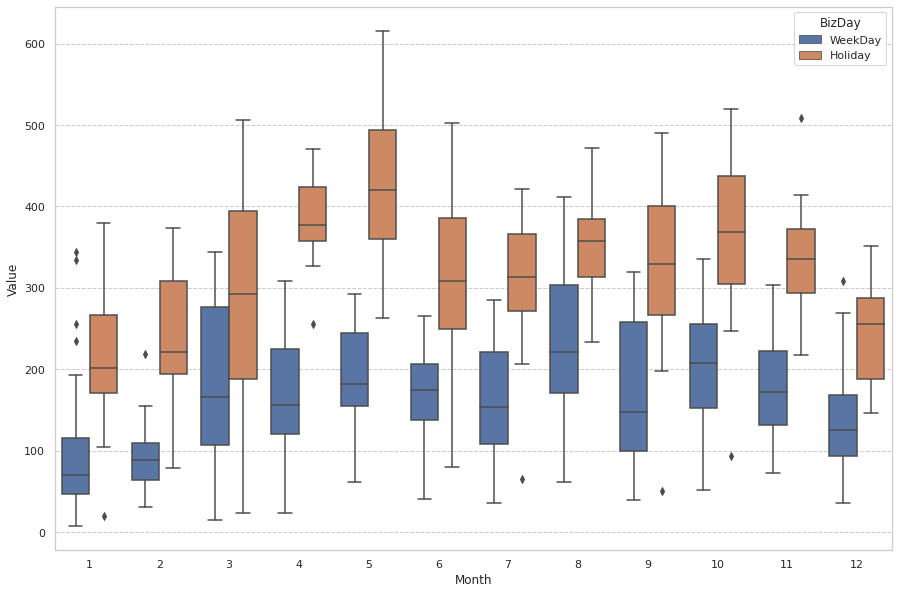

In [33]:
# 月別の入場者数の分析

df6 = df3.loc[df3['Metric'].isin(['Quantity'])]
sns.boxplot(data = df6, x="Month", y="Value", hue="BizDay")

## アジの釣果サイズの比較

<AxesSubplot:xlabel='Metric', ylabel='Value'>

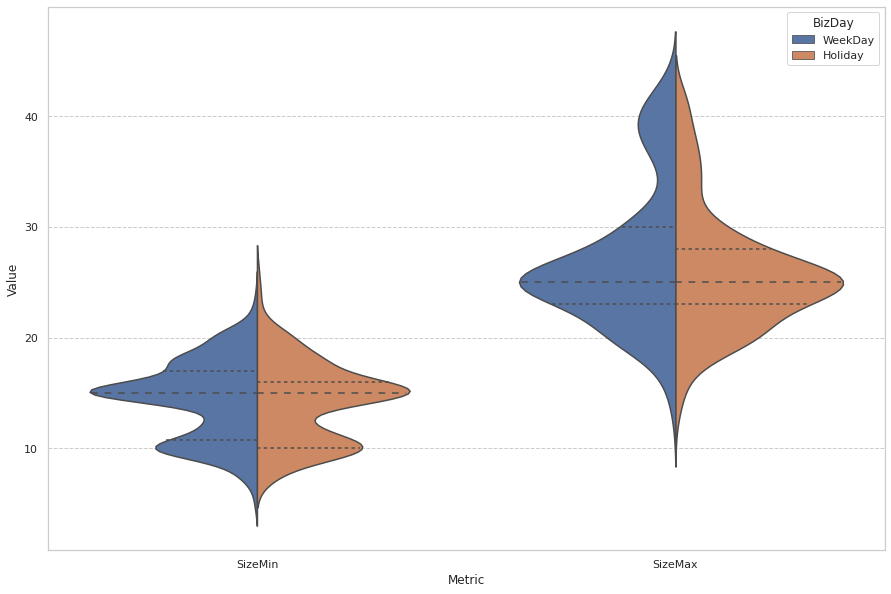

In [34]:
# アジの最小、最大サイズに絞り込んで平日、休日の分布図を比較

df5 = df3.loc[df3['Metric'].isin(['SizeMax', 'SizeMin'])]
sns.violinplot(data = df5, x="Metric", y="Value", hue="BizDay", 
               split=True, inner="quart")

<AxesSubplot:xlabel='Month', ylabel='Value'>

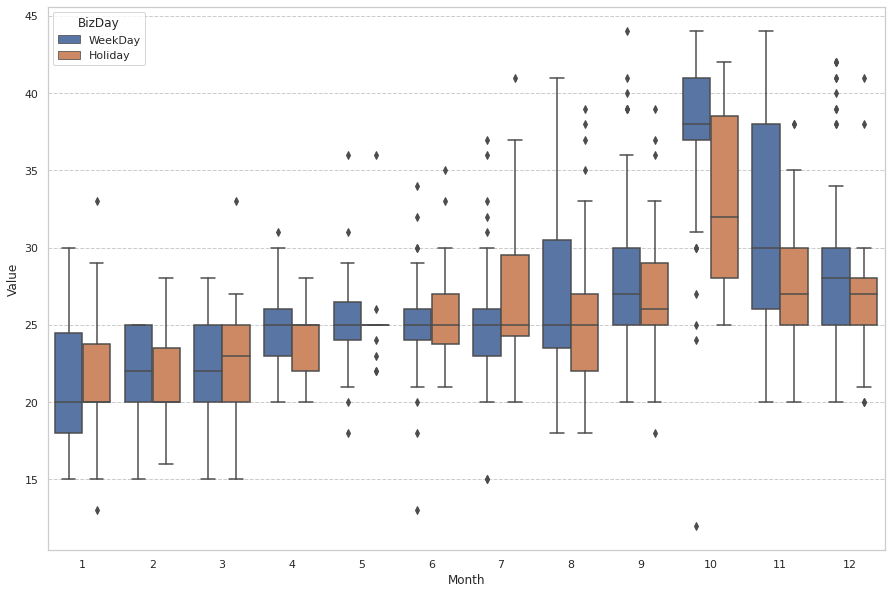

In [35]:
# 月別のアジ最大サイズの分析

df6 = df3.loc[df3['Metric'].isin(['SizeMax'])]
sns.boxplot(data = df6, x="Month", y="Value", hue="BizDay")

## 年度別のアジ釣果分析

<AxesSubplot:xlabel='Month', ylabel='Value'>

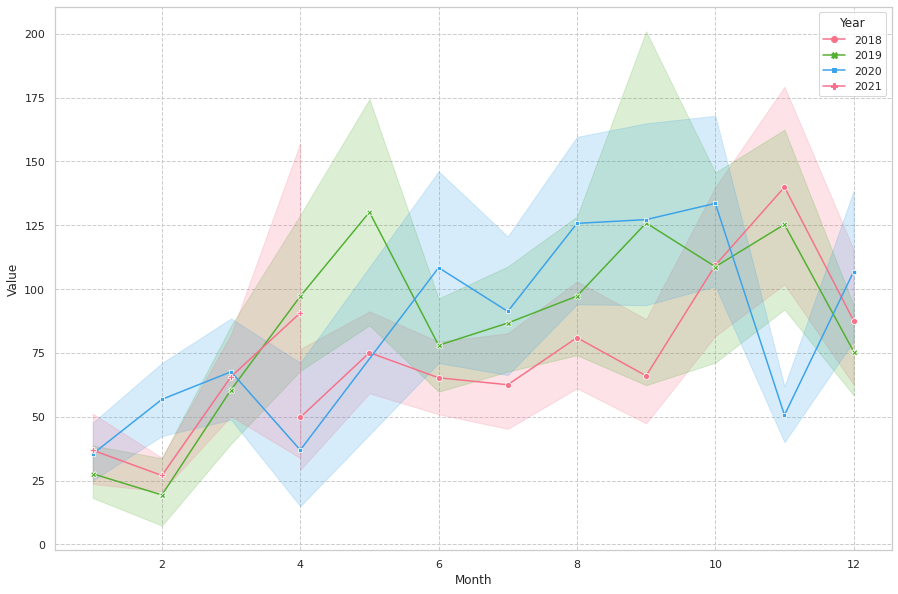

In [36]:
# 平日の釣果に絞り込む

df7 = df3.query('BizDay == "WeekDay"')

# 年度別アジ釣果数の比較

df8 = df7.loc[df7['Metric'].isin(['Count'])]
sns.lineplot(data=df7, x='Month', y='Value', hue='Year', style='Year',
            markers=True, dashes=False, palette="husl")

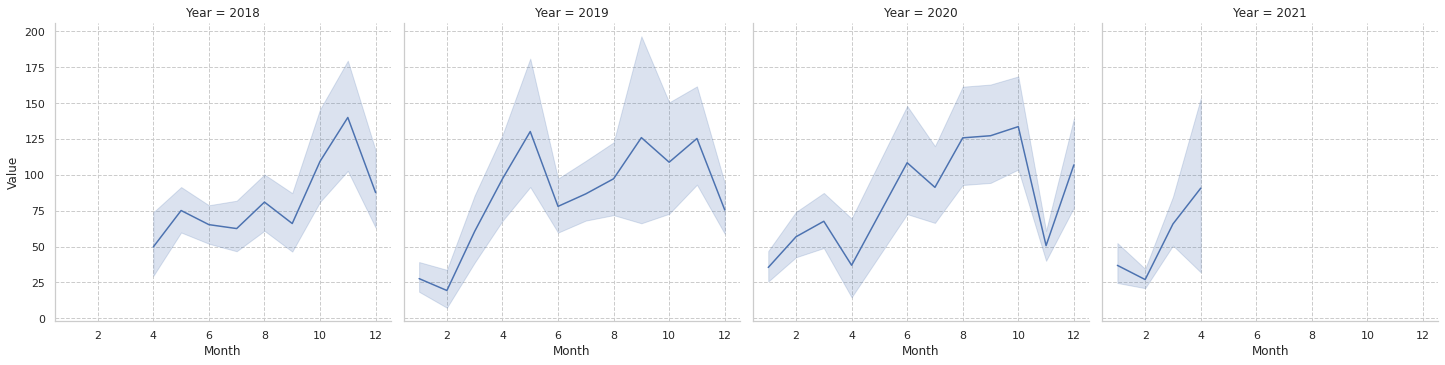

In [37]:
# 年度別アジ釣果数

sns.relplot(data=df7, x='Month', y='Value', col='Year', kind="line")

<AxesSubplot:xlabel='Month', ylabel='Value'>

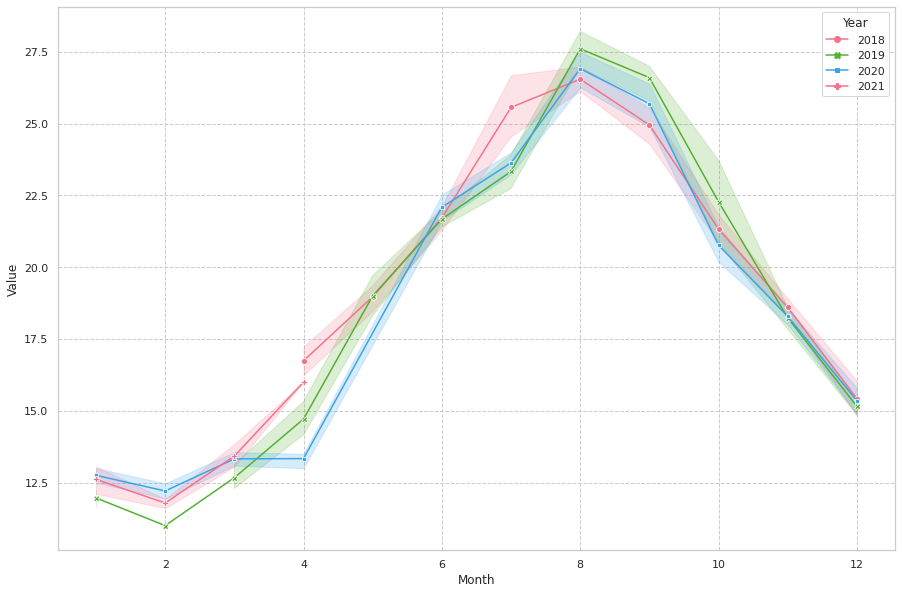

In [38]:
# 海水温の比較

df9 = df7.loc[df7['Metric'].isin(['WaterTemp'])]
sns.lineplot(data=df9, x='Month', y='Value', hue='Year', style='Year',
            markers=True, dashes=False, palette="husl")

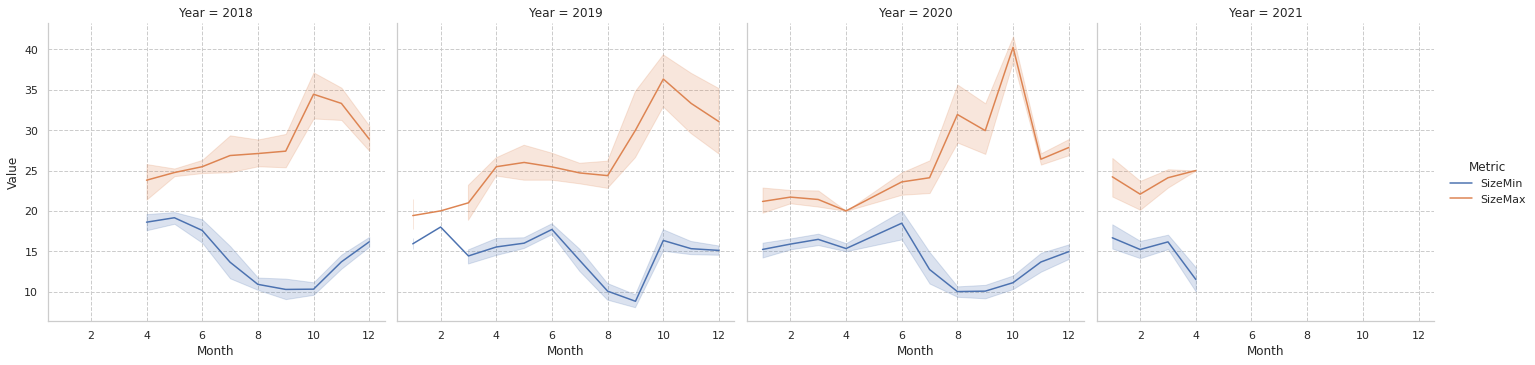

In [39]:
# アジ釣果サイズの比較

df10 = df7.loc[df7['Metric'].isin(['SizeMin', 'SizeMax'])]
sns.relplot(data=df10, x='Month', y='Value', hue='Metric', col='Year', kind="line")

<AxesSubplot:xlabel='Month', ylabel='Value'>

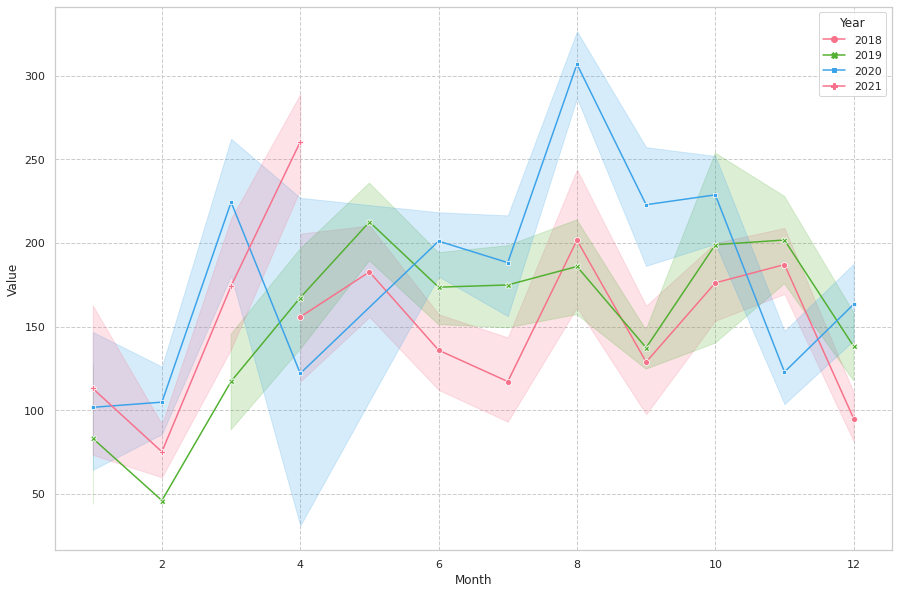

In [40]:
# 年度別入場者数

df11 = df7.loc[df7['Metric'].isin(['Quantity'])]
sns.lineplot(data=df11, x='Month', y='Value', hue='Year', style='Year',
            markers=True, dashes=False, palette="husl")

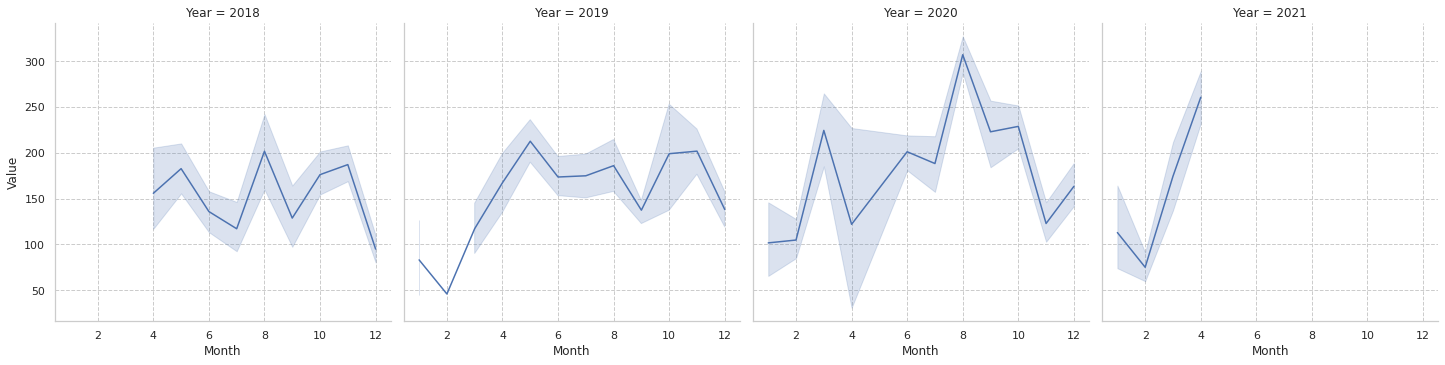

In [41]:
# 年度別入場者数、各年度グラフ

sns.relplot(data=df11, x='Month', y='Value', col='Year', kind="line")